# Week 3: Policy Gradient Methods
## Lecture Demonstration



## 1. Recap: Value-Based vs Policy-Based

### Value-Based (Q-Learning)
- Learn Q(s,a) for all state-action pairs
- Policy is **implicit**: π(s) = argmax_a Q(s,a)
- Works well for discrete actions
- Policy is always deterministic

### Policy-Based (Today)
- Learn policy **directly**: π_θ(a|s)
- No need for value function (though we can add one later!)
- Can handle continuous actions naturally
- Can learn stochastic policies

### Why Policy Gradient?
1. **Continuous actions**: Can't do argmax over infinite actions
2. **Stochastic policies**: Sometimes randomness is optimal (e.g., rock-paper-scissors)
3. **Smoother optimization**: Small parameter changes → small policy changes
4. **Convergence guarantees**: Under certain conditions, guaranteed to converge

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
from matplotlib import animation
from IPython.display import HTML

np.random.seed(42)
torch.manual_seed(42)

## 2. Policy Gradient Theorem

### Goal
Maximize expected return:
$$J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta}\left[\sum_{t=0}^T \gamma^t r_t\right]$$

Where τ (tau) is a trajectory: (s₀, a₀, r₀, s₁, a₁, r₁, ...)

### The Key Insight
We can't differentiate through the environment (stochastic!), but we can use the **log-derivative trick**:

$$\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta}\left[\sum_{t=0}^T \nabla_\theta \log \pi_\theta(a_t|s_t) \cdot G_t\right]$$

Where:
- $G_t = \sum_{k=t}^T \gamma^{k-t} r_k$ is the return from time t
- $\nabla_\theta \log \pi_\theta(a_t|s_t)$ is the gradient of log probability

### Intuition
- If action led to high return → increase its probability
- If action led to low return → decrease its probability
- The gradient tells us which direction to adjust parameters

## 3. REINFORCE Algorithm

**Monte Carlo Policy Gradient** (Williams, 1992)

```
Initialize policy network π_θ with random weights θ

for episode = 1 to N:
    Generate episode: s₀, a₀, r₀, ..., s_T, a_T, r_T using π_θ
    
    for t = 0 to T:
        Compute return: G_t = Σ γ^k r_{t+k}
        
    Compute loss: L = -Σ log π_θ(a_t|s_t) * G_t
    
    Update θ using gradient descent on L
```

### Why the Negative Sign?
- We want to **maximize** J(θ)
- Optimizers **minimize** loss
- So we minimize -J(θ), which is the same as maximizing J(θ)

## 4. Toy Example: 2-State MDP

Let's see policy gradients on the simplest possible problem.

**Setup:**
- 2 states: {0, 1}
- 2 actions: {left, right}
- Start in state 0
- Reward: +1 if you reach state 1, 0 otherwise
- Episode ends when you reach state 1

**Optimal policy:** Always go right from state 0

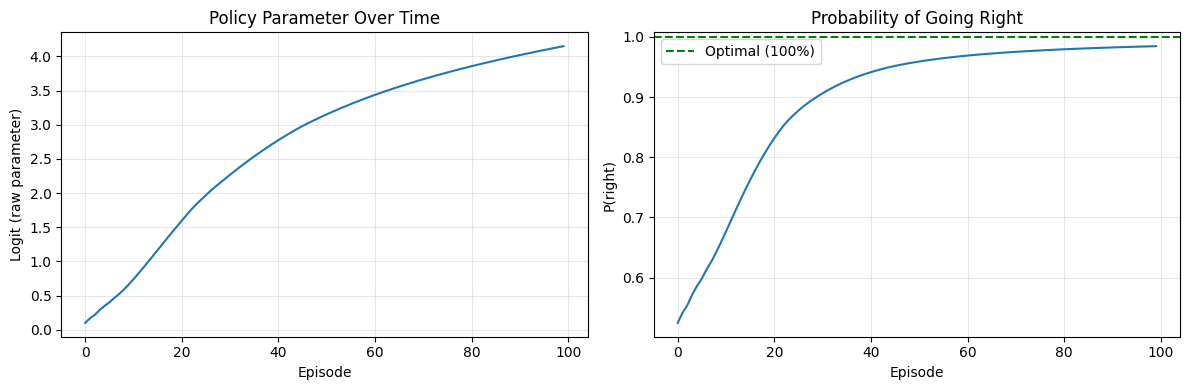


Final probability of going right: 0.984
(Optimal: 1.0)


In [6]:
class TinyPolicyNetwork(nn.Module):
    """Simplest possible policy network."""
    
    def __init__(self):
        super().__init__()
        # Just a single parameter: logit for "right" action
        self.logit = nn.Parameter(torch.tensor(0.0))  # Make this a scalar, not a 1-element tensor
    
    def forward(self, state):
        # Probability of going right
        prob_right = torch.sigmoid(self.logit)
        return torch.stack([1 - prob_right, prob_right])


def toy_environment(action):
    """Simple 2-state MDP."""
    if action == 1:  # right
        return 1, 1.0, True  # next_state, reward, done
    else:  # left
        return 0, 0.0, False  # stay in state 0, no reward


# Train the tiny policy
policy = TinyPolicyNetwork()
optimizer = optim.Adam(policy.parameters(), lr=0.1)

logits_history = []
prob_right_history = []

for episode in range(100):
    # Sample action
    probs = policy(None)
    action = torch.multinomial(probs, 1).item()
    
    # Take action
    next_state, reward, done = toy_environment(action)
    
    # Compute loss
    log_prob = torch.log(probs[action])
    loss = -log_prob * reward  # Policy gradient
    
    # Update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Track
    logits_history.append(policy.logit.item())
    prob_right_history.append(torch.sigmoid(policy.logit).item())

# Plot learning
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(logits_history)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Logit (raw parameter)')
ax1.set_title('Policy Parameter Over Time')
ax1.grid(True, alpha=0.3)

ax2.plot(prob_right_history)
ax2.axhline(y=1.0, color='g', linestyle='--', label='Optimal (100%)')
ax2.set_xlabel('Episode')
ax2.set_ylabel('P(right)')
ax2.set_title('Probability of Going Right')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal probability of going right: {prob_right_history[-1]:.3f}")
print("(Optimal: 1.0)")

**Observation:** The policy learns to go right (optimal!) through trial and error.

Notice the **credit assignment**: When we go right and get reward=1, we increase P(right). When we go left and get reward=0, we don't change P(left) much (because gradient is near zero).

## 5. CartPole Environment

Now let's tackle a real problem: **CartPole-v1**

**Goal:** Balance a pole on a moving cart

**State:** 4 continuous values
- Cart position: [-4.8, 4.8]
- Cart velocity: [-∞, ∞]
- Pole angle: [-0.418, 0.418] rad (~24°)
- Pole angular velocity: [-∞, ∞]

**Actions:** 2 discrete
- 0: Push cart left
- 1: Push cart right

**Reward:** +1 for every timestep the pole stays up

**Episode ends if:**
- Pole angle > 12°
- Cart position > 2.4
- 500 timesteps elapsed

**Success criterion:** Average reward ≥ 475 over 100 episodes

In [7]:
# Create environment
env = gym.make('CartPole-v1')

print("CartPole-v1 Environment:")
print(f"  State space: {env.observation_space}")
print(f"  Action space: {env.action_space}")
print(f"  Max episode steps: {env.spec.max_episode_steps}")

# Test random policy
state, _ = env.reset(seed=42)
print(f"\nInitial state: {state}")
print(f"  [cart_pos, cart_vel, pole_angle, pole_ang_vel]")

CartPole-v1 Environment:
  State space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
  Action space: Discrete(2)
  Max episode steps: 500

Initial state: [ 0.0273956  -0.00611216  0.03585979  0.0197368 ]
  [cart_pos, cart_vel, pole_angle, pole_ang_vel]


## 6. Policy Network for CartPole

In [9]:
class PolicyNetwork(nn.Module):
    """Neural network policy for CartPole."""
    
    def __init__(self, state_dim=4, hidden_dim=32, action_dim=2):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
    
    def forward(self, state):
        """Forward pass: state → action logits."""
        return self.network(state)
    
    def get_action_probs(self, state):
        """Get action probabilities using softmax."""
        logits = self.forward(state)
        return torch.softmax(logits, dim=-1)
    
    def select_action(self, state):
        """Sample action from policy and return (action, log_prob)."""
        state = torch.FloatTensor(state)
        probs = self.get_action_probs(state)
        
        # Sample action from categorical distribution
        action = torch.multinomial(probs, 1).item()
        log_prob = torch.log(probs[action])
        
        return action, log_prob


# Test the policy
policy = PolicyNetwork()
test_state = np.array([0.0, 0.0, 0.0, 0.0])

print("Testing policy network:")
for _ in range(3):
    action, log_prob = policy.select_action(test_state)
    print(f"  Action: {action}, log P(a|s): {log_prob.item():.3f}")

Testing policy network:
  Action: 0, log P(a|s): -0.745
  Action: 1, log P(a|s): -0.644
  Action: 1, log P(a|s): -0.644


## 7. REINFORCE Implementation

In [10]:
def compute_returns(rewards, gamma=0.99):
    """
    Compute discounted returns for each timestep.
    
    G_t = r_t + γ*r_{t+1} + γ²*r_{t+2} + ...
    """
    returns = []
    R = 0
    
    # Work backwards from end of episode
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    
    return torch.FloatTensor(returns)


def train_reinforce(env, policy, optimizer, n_episodes=1000, gamma=0.99):
    """Train policy using REINFORCE algorithm."""
    episode_rewards = []
    
    for episode in range(n_episodes):
        # Sample episode
        log_probs = []
        rewards = []
        
        state, _ = env.reset()
        done = False
        
        while not done:
            action, log_prob = policy.select_action(state)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            log_probs.append(log_prob)
            rewards.append(reward)
        
        # Compute returns
        returns = compute_returns(rewards, gamma)
        
        # Normalize returns (variance reduction)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        
        # Compute policy gradient loss
        loss = 0
        for log_prob, G in zip(log_probs, returns):
            loss += -log_prob * G
        
        # Update policy
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track performance
        episode_rewards.append(sum(rewards))
        
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            print(f"Episode {episode + 1}: Avg Reward = {avg_reward:.2f}")
    
    return episode_rewards


# Train the policy
print("Training REINFORCE on CartPole-v1...\n")

env = gym.make('CartPole-v1')
policy = PolicyNetwork()
optimizer = optim.Adam(policy.parameters(), lr=0.01)

rewards = train_reinforce(env, policy, optimizer, n_episodes=1000)

print(f"\nFinal 100-episode average: {np.mean(rewards[-100:]):.2f}")

Training REINFORCE on CartPole-v1...

Episode 100: Avg Reward = 74.55
Episode 100: Avg Reward = 74.55
Episode 200: Avg Reward = 300.40
Episode 200: Avg Reward = 300.40
Episode 300: Avg Reward = 248.88
Episode 300: Avg Reward = 248.88
Episode 400: Avg Reward = 500.00
Episode 400: Avg Reward = 500.00
Episode 500: Avg Reward = 500.00
Episode 500: Avg Reward = 500.00
Episode 600: Avg Reward = 423.25
Episode 600: Avg Reward = 423.25
Episode 700: Avg Reward = 108.58
Episode 700: Avg Reward = 108.58
Episode 800: Avg Reward = 91.44
Episode 800: Avg Reward = 91.44
Episode 900: Avg Reward = 390.04
Episode 900: Avg Reward = 390.04
Episode 1000: Avg Reward = 489.33

Final 100-episode average: 489.33
Episode 1000: Avg Reward = 489.33

Final 100-episode average: 489.33


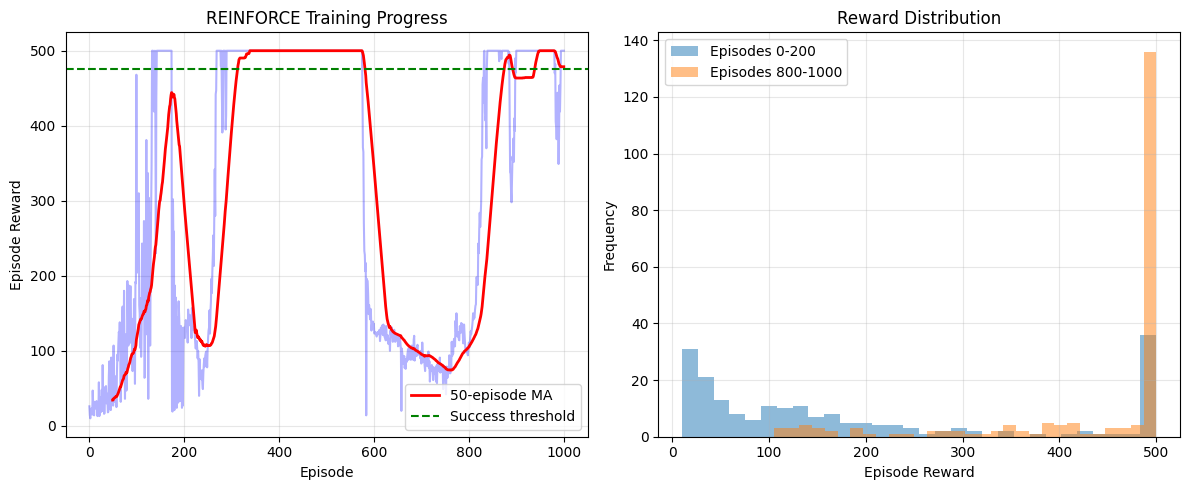

In [11]:
# Plot learning curve
plt.figure(figsize=(12, 5))

# Raw rewards
plt.subplot(1, 2, 1)
plt.plot(rewards, alpha=0.3, color='blue')
# Moving average
window = 50
moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
plt.plot(range(window-1, len(rewards)), moving_avg, color='red', linewidth=2, label=f'{window}-episode MA')
plt.axhline(y=475, color='g', linestyle='--', label='Success threshold')
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.title('REINFORCE Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)

# Distribution of rewards
plt.subplot(1, 2, 2)
plt.hist(rewards[:200], bins=30, alpha=0.5, label='Episodes 0-200')
plt.hist(rewards[-200:], bins=30, alpha=0.5, label='Episodes 800-1000')
plt.xlabel('Episode Reward')
plt.ylabel('Frequency')
plt.title('Reward Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Visualizing the Trained Policy

In [12]:
def display_episode(env, policy, max_steps=500):
    """Record episode and display as animation."""
    frames = []
    state, _ = env.reset()
    
    for _ in range(max_steps):
        # Render
        frame = env.render()
        frames.append(frame)
        
        # Select action (greedy, no exploration)
        state_tensor = torch.FloatTensor(state)
        with torch.no_grad():
            probs = policy.get_action_probs(state_tensor)
            action = torch.argmax(probs).item()
        
        # Step
        state, reward, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            break
    
    env.close()
    
    # Create animation
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.axis('off')
    img = ax.imshow(frames[0])
    
    def animate(i):
        img.set_data(frames[i])
        return [img]
    
    anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=20, blit=True)
    plt.close()
    
    return HTML(anim.to_html5_video())


# Display trained policy
env = gym.make('CartPole-v1', render_mode='rgb_array')
print("Trained policy in action:")
display_episode(env, policy)

Trained policy in action:


## 9. Variance Reduction: Adding a Baseline

### Problem
Policy gradients have **high variance**:
- Even good actions might get low returns due to randomness
- This makes learning unstable and slow

### Solution: Baseline
Subtract a baseline b(s) from returns:
$$\nabla_\theta J(\theta) = \mathbb{E}\left[\nabla_\theta \log \pi_\theta(a|s) \cdot (G_t - b(s_t))\right]$$

**Key insight:** This doesn't change the expectation (bias), but reduces variance!

**Common baseline:** Average return across the episode

**Better baseline:** Value function V(s) → leads to Actor-Critic (next week!)

Comparing with/without baseline...


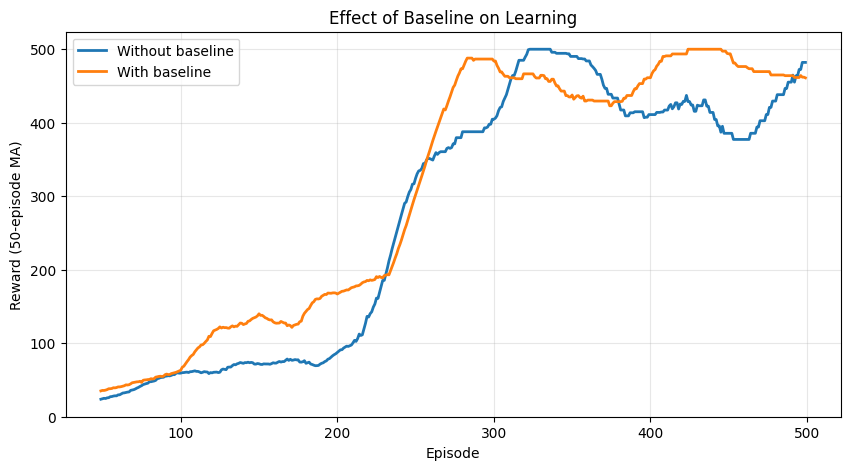


Baseline typically leads to:
  - Faster learning
  - More stable training
  - Better final performance


In [13]:
# We already used return normalization above, which is a form of baseline!
# Let's compare with and without:

def train_comparison():
    """Compare with/without baseline."""
    results = {}
    
    for use_baseline in [False, True]:
        env = gym.make('CartPole-v1')
        policy = PolicyNetwork()
        optimizer = optim.Adam(policy.parameters(), lr=0.01)
        rewards = []
        
        for episode in range(500):
            log_probs = []
            episode_rewards = []
            
            state, _ = env.reset()
            done = False
            
            while not done:
                action, log_prob = policy.select_action(state)
                state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                
                log_probs.append(log_prob)
                episode_rewards.append(reward)
            
            returns = compute_returns(episode_rewards, gamma=0.99)
            
            if use_baseline:
                # Normalize returns (subtract mean, divide by std)
                returns = (returns - returns.mean()) / (returns.std() + 1e-8)
            
            loss = sum(-lp * G for lp, G in zip(log_probs, returns))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            rewards.append(sum(episode_rewards))
        
        results[use_baseline] = rewards
    
    return results


print("Comparing with/without baseline...")
comparison = train_comparison()

plt.figure(figsize=(10, 5))
for use_baseline, rewards in comparison.items():
    window = 50
    moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
    label = 'With baseline' if use_baseline else 'Without baseline'
    plt.plot(range(window-1, len(rewards)), moving_avg, label=label, linewidth=2)

plt.xlabel('Episode')
plt.ylabel('Reward (50-episode MA)')
plt.title('Effect of Baseline on Learning')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\nBaseline typically leads to:")
print("  - Faster learning")
print("  - More stable training")
print("  - Better final performance")

## 10. Key Takeaways

### REINFORCE Summary
1. **Direct policy optimization**: Learn π_θ(a|s) directly
2. **Monte Carlo**: Use full episode returns
3. **Policy gradient theorem**: ∇J = E[∇log π * G]
4. **Simple but effective**: Works for continuous and discrete actions

### Advantages
- Can learn stochastic policies
- Works with continuous action spaces
- Guaranteed convergence (to local optimum)
- Simple to implement

### Disadvantages
- High variance → slow learning
- Sample inefficient (on-policy, Monte Carlo)
- Can get stuck in local optima
- Sensitive to hyperparameters

### Improvements (Next Steps)
1. **Baselines**: Reduce variance → Actor-Critic
2. **Bootstrapping**: Use TD instead of MC → A2C, A3C
3. **Trust regions**: Constrain updates → PPO, TRPO
4. **Off-policy**: Reuse data → DDPG, SAC

---

## Next: Lab Exercise
You'll implement REINFORCE yourself and train an agent to solve CartPole!